# Finding the k in k-anonymity
All the other suppresion methods rely on a specific k. This notebook is all about finding the specific k we wanna use for each dataset

In [39]:
from anjana.anonymity import k_anonymity
from masking_effects_on_xai_techniques.hierarchies import generate_hierarchy
import masking_effects_on_xai_techniques.anonymized_preprocessor as anon_prep
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
path = "../data/adult/"

In [3]:
data = pd.read_csv(path + "data.csv")
len_data = len(data)

# Clean the data
data['income'] = data['income'].str.rstrip('.')
data.dropna(inplace=True)
data.drop(columns=['education-num', 'fnlwgt'], inplace=True)

len_clean_data = len(data)
print(f"Dropped {len_data - len_clean_data} rows")
data.to_csv(path + "clean.csv", index=False)

Dropped 1221 rows


In [4]:
hierarchies = {
    "age": dict(pd.read_csv("../hierarchies/age.csv", header=None)),
    "education": dict(pd.read_csv("../hierarchies/education.csv", header=None)),
    "marital-status": dict(pd.read_csv("../hierarchies/marital.csv", header=None)),
    "occupation": dict(pd.read_csv("../hierarchies/occupation.csv", header=None)),
    "sex": dict(pd.read_csv("../hierarchies/sex.csv", header=None)),
    "native-country": dict(pd.read_csv("../hierarchies/country.csv", header=None)),
    "workclass": dict(pd.read_csv("../hierarchies/workclass.csv", header=None)),
    "relationship": dict(pd.read_csv("../hierarchies/relationship.csv", header=None)),
    "race": dict(pd.read_csv("../hierarchies/race.csv", header=None)),
    "capital-gain": generate_hierarchy(data['capital-gain'], 8),
    "capital-loss": generate_hierarchy(data['capital-loss'], 6),
    "hours-per-week": generate_hierarchy(data['hours-per-week'], 5),
}

In [5]:
quasi_ident = list(data.columns)
quasi_ident.remove('race')
quasi_ident.remove('income')

ident = ['race'] # Making race quasi identifier make k much larger
sens_att = 'income'

In [8]:
target_dir = Path("../data/adult/k_anonymity").resolve()
    
# 2. Use glob('*') and filter for only files
files = [f for f in target_dir.glob('*') if f.is_file()]
files = sorted(files, key=lambda p: int(p.name.rstrip('.csv')))
files

[PosixPath('/home/kochc/projects/bachelor/Masking-Effects-on-XAI-Techniques/data/adult/k_anonymity/2.csv'),
 PosixPath('/home/kochc/projects/bachelor/Masking-Effects-on-XAI-Techniques/data/adult/k_anonymity/4.csv'),
 PosixPath('/home/kochc/projects/bachelor/Masking-Effects-on-XAI-Techniques/data/adult/k_anonymity/8.csv'),
 PosixPath('/home/kochc/projects/bachelor/Masking-Effects-on-XAI-Techniques/data/adult/k_anonymity/16.csv'),
 PosixPath('/home/kochc/projects/bachelor/Masking-Effects-on-XAI-Techniques/data/adult/k_anonymity/32.csv'),
 PosixPath('/home/kochc/projects/bachelor/Masking-Effects-on-XAI-Techniques/data/adult/k_anonymity/64.csv'),
 PosixPath('/home/kochc/projects/bachelor/Masking-Effects-on-XAI-Techniques/data/adult/k_anonymity/128.csv'),
 PosixPath('/home/kochc/projects/bachelor/Masking-Effects-on-XAI-Techniques/data/adult/k_anonymity/256.csv')]

In [24]:
load_from_files = True
k_list = [2 ** n for n in range(1,9)]
supp_level = 20
anon_data = []
if load_from_files:
    target_dir = Path("../data/adult/k_anonymity").resolve()
    files = [f for f in target_dir.glob('*') if f.is_file()]
    files = sorted(files, key=lambda p: int(p.name.rstrip('.csv')))
    files
    for file in files:
        anon_data.append(pd.read_csv(file).iloc[:,1:]) # ignore index col
else:
    for k in k_list: 
        print(f"Anonymizing for k={k}")
        anon_df = k_anonymity_inner(
            data, ident, quasi_ident, k, supp_level, hierarchies
        )
        anon_data.append(anon_df)
    print("Done anonymizing")

In [35]:
scores = []
for df in anon_data:
    df = anon_prep.encode(df, hierarchy_path="../hierarchies/")
    y = df['income']
    X = df.drop(columns=['income'])
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=0
    )
    clf = MLPClassifier(
        solver="sgd", alpha=1e-5, hidden_layer_sizes=(10), random_state=1
    )
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    scores.append(score)
    print(score)

/home/kochc/projects/bachelor/Masking-Effects-on-XAI-Techniques/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.8084776267610004
0.808505315822389
0.814250991428937
0.8185737159748737
0.8238186462324394
0.8213381789863067
0.8201354679802956
0.821926652892562


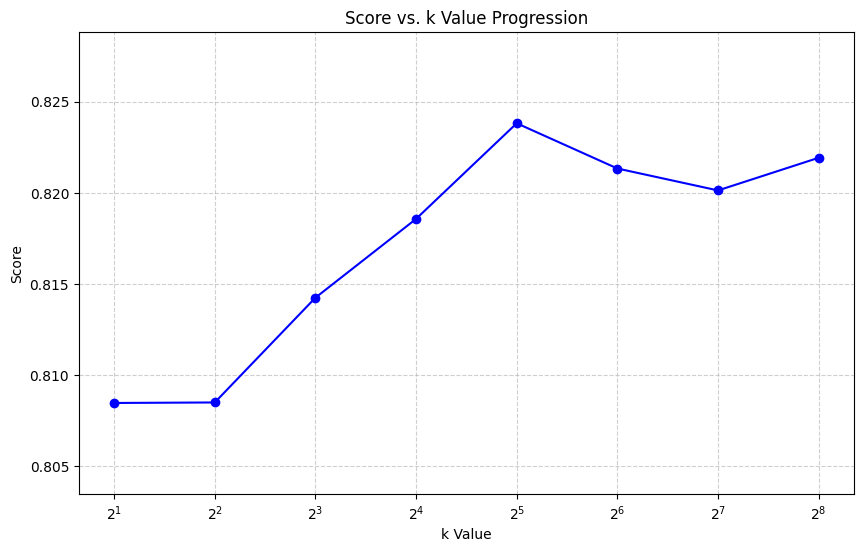

In [50]:
df = pd.DataFrame({'k_value': k_list, 'Score': scores})


plt.figure(figsize=(10, 6))


plt.plot(df['k_value'], df['Score'], marker='o', linestyle='-', color='blue')

plt.xscale('log', base=2)

plt.xlabel('k Value')
plt.ylabel('Score')
plt.title('Score vs. k Value Progression')


plt.grid(True, linestyle='--', alpha=0.6)


plt.xticks(k_list)


min_score = min(scores) - 0.005
max_score = max(scores) + 0.005
plt.ylim(min_score, max_score)
plt.show()

Utility is not affected a lot by k. So we can choose it rather freely
Choosing $k=2^4=16$ is a good tradeoff between privacy and accuracy